# Cluster-I workflow

This notebook presents a computational workflow to detect trees from aerial imagery with a train/test split of image tiles based on a *k*-means clustering of image descriptors that enhances the variety of scenes represented in the training tiles.

In order to avoid issues with relative paths, let us first of all change the working directory to the repository's root

In [ ]:
%cd ..

/home/martibosch/data-science/detectree-examples


In [ ]:
import os
from os import path

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot

from detectree_examples import make_confusion_df, make_response_tiles

random_state = 10
figwidth, figheight = plt.rcParams["figure.figsize"]
%matplotlib inline

Let us now use the Makefile at the root of this repository ensure that we have the required data input data - i.e., the tiles from [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) that lie within Zurich's municipal boundaries - has been downloaded (see [the background notebook](https://github.com/martibosch/detectree-example/blob/main/notebooks/background.ipynb) for more details).

In [ ]:
!make tiles

make: Nothing to be done for 'tiles'.


## Train/test split

In order to select which image tiles are to be used to train the classifier, we will follow the 'Cluster-I' method described in Yang et al. [1], which consists of the following steps (see [the background notebook](https://github.com/martibosch/detectree-example/blob/main/notebooks/background.ipynb) for more details on the procedure):

1. Compute image descriptors [2] for each tile of the dataset
2. Apply *k*-means to the image descriptors, with the number of clusters that corresponds to the number of tiles that are to be used to train the classifier, i.e., for our Zurich dataset of 225 tiles and a desired 1% of training tiles, the number of clusters could be set to 2 or 3
3. Select the tiles that are closest to each cluster's centroid for training

In detectree, the above procedure is done with the `train_test_split` method of the `TrainingSelector` class. Note that the initialization of `TrainingSelector` accepts a set of keyword arguments to customize how the image descriptors are computed (see [its documentation](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) for more details).

In [ ]:
ts = dtr.TrainingSelector(img_dir="data/interim/tiles")

In order to reduce the computational cost of the *k*-means clustering, Principal Component Analysis (PCA) is be used to reduce the dimensionality of the image descriptors, e.g., to 24 components. This is specified in the `n_components` keyword argument of the `train_test_split` method.

After the instantiation of a `TrainingSelector`, its `train_test_split` method can be used as follows (the processing can take a while since it involves the computation of the image descriptor for each tile):

In [ ]:
split_df, evr = ts.train_test_split(
    method="cluster-I",
    n_components=24,
    return_evr=True,
    pca_kwargs={"random_state": random_state},
    kmeans_kwargs={"random_state": random_state},
)

[########################################] | 100% Completed | 48.31 s


The `train_test_split` method returns a pandas data frame with the train test split. Additionally, if `return_evr` is `True`, `train_test_split` also returns the variance ratio explained by the PCA, which in this case is:

In [ ]:
evr

0.9187597910082324

The data frame of the train/test split looks as follows:

In [ ]:
split_df.head()

,img_filepath,train
0,data/interim/tiles/1091-232_01.tif,False
1,data/interim/tiles/1091-411_23.tif,False
2,data/interim/tiles/1091-411_04.tif,False
3,data/interim/tiles/1091-322_05.tif,True
4,data/interim/tiles/1091-411_02.tif,False


The tiles to be used for training are the following ones:

In [ ]:
split_df[split_df["train"]]

,img_filepath,train
3,data/interim/tiles/1091-322_05.tif,True
23,data/interim/tiles/1091-322_01.tif,True
62,data/interim/tiles/1091-431_14.tif,True
250,data/interim/tiles/1091-431_22.tif,True


## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained.

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [ ]:
!make download_lidar_shp

make: Nothing to be done for 'download_lidar_shp'.


In [ ]:
lidar_gdf = gpd.read_file("data/raw/lidar/lidar2014.shp")
# lidar_gdf.iloc[:20].plot(edgecolor=(0,0,0))

response_dir = "data/interim/response-tiles"
if not path.exists(response_dir):
    os.mkdir(response_dir)

make_response_tiles.make_response_tiles(
    split_df,
    lidar_gdf,
    "data/raw/lidar",
    response_dir,
)

['data/interim/response-tiles/1091-322_05.tif',
 'data/interim/response-tiles/1091-322_01.tif',
 'data/interim/response-tiles/1091-431_14.tif',
 'data/interim/response-tiles/1091-431_22.tif']

Let us now plot side by side the training tiles (left) and the LIDAR-based ground-truth masks.

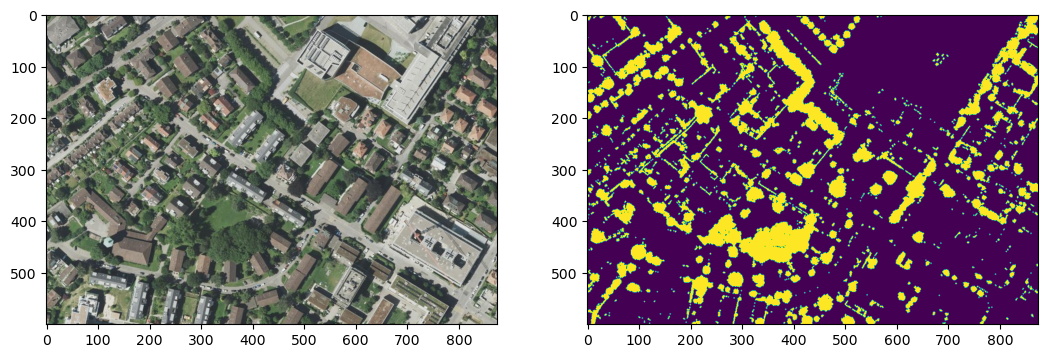

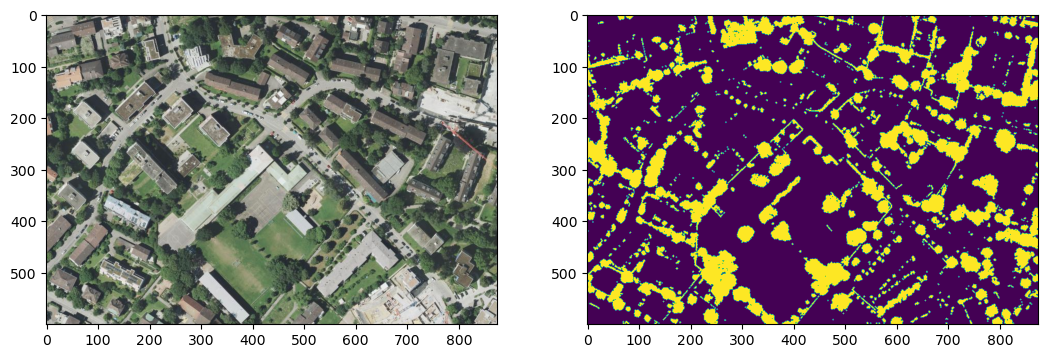

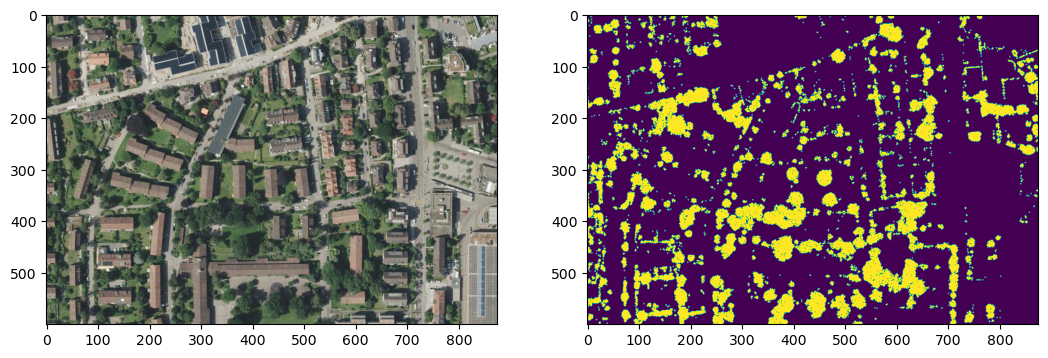

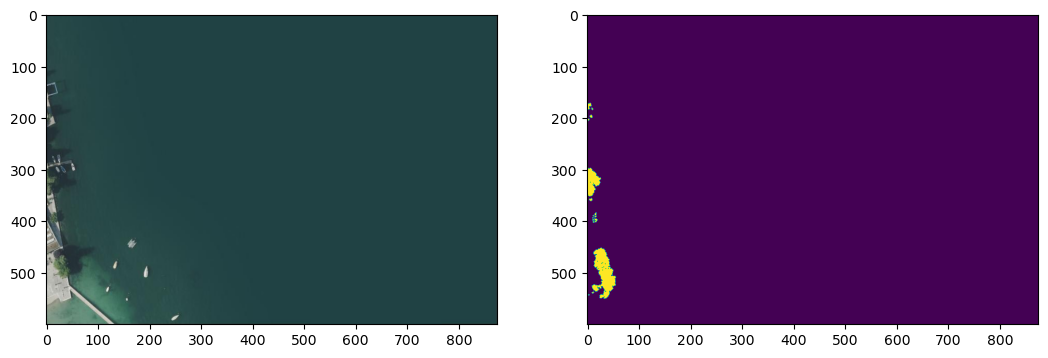

In [ ]:
for img_filepath in split_df[split_df["train"]]["img_filepath"]:
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    with rio.open(img_filepath) as src:
        plot.show(src.read(), ax=axes[0])
    with rio.open(path.join(response_dir, path.basename(img_filepath))) as src:
        plot.show(src.read(), ax=axes[1])

Note that accuracy of the ground-truth masks is crucial to train a good classifier.


## Training the classifier

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifier` method of the `ClassifierTrainer` class, which accepts the train/test split data frame as the `split_df` keyword argument (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.train_classifier) for more details). The training of the classifier can be customized by providing a set of keyword arguments to the initialization of `ClassifierTrainer` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.__init__) for more details). Note that the training of the classifier can take some time.

In [ ]:
clf = dtr.ClassifierTrainer(random_state=random_state).train_classifier(
    split_df=split_df, response_img_dir=response_dir
)

[########################################] | 100% Completed | 3.05 ss
[LightGBM] [Info] Number of positive: 344983, number of negative: 1755017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.354397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6865
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164278 -> initscore=-1.626739
[LightGBM] [Info] Start training from score -1.626739


## Predicting tree/non-tree labels

Once the classifier has been trained, it can be used to predict the tree/non-tree labels from any given image. To that end, detectree provides the `Classifier` class, which features a `predict_img` method that can be (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_img) for more details).

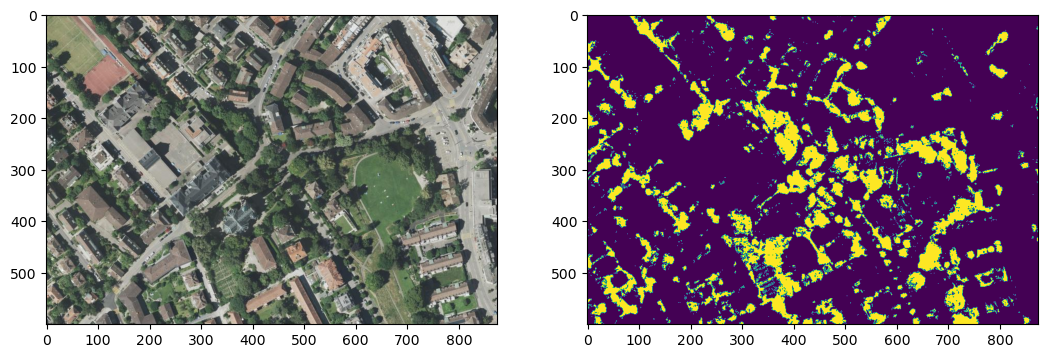

In [ ]:
test_filepath = split_df[~split_df["train"]].sample(1).iloc[0]["img_filepath"]

c = dtr.Classifier(clf=clf)
y = c.predict_img(test_filepath)

fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(test_filepath) as src:
    plot.show(src.read(), ax=axes[0])
axes[1].imshow(y)

In order to segment multiple tiles in a single command, we might use [the `predict_imgs` method](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_imgs), which uses dask to segment the tiles in parallel.

## Validation

In order to evaluate the accuracy of the classifier, we can use the code below to build a confusion matrix, which uses the LIDAR dataset to compute the ground-truth masks. The `frac` keyword argument sets the fraction of tiles that will be randomly-sampled and used for validation.

In [ ]:
confusion_df = make_confusion_df.make_confusion_df(
    lidar_gdf, "data/raw/lidar", response_dir, split_df=split_df, frac=0.01, clf=clf
)
confusion_df

[########################################] | 100% Completed | 235.00 s


predicted,0,255
actual,,
0,0.605768,0.041580
255,0.065237,0.287415


We can compute the accuracy, precision, recall and F1-score from the confusion matrix:

In [ ]:
accuracy, precision, recall, f1 = make_confusion_df.compute_metrics(confusion_df)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8931828571428571
Precision: 0.8736160349848602
Recall: 0.8150093261412821
F1: 0.8432956561831976


## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.

2. Oliva, A., & Torralba, A. (2001). Modeling the shape of the scene: A holistic representation of the spatial envelope. International journal of computer vision, 42(3), 145-175.